
# Set Cover Problem


## Introduction

The set cover problem [[1]](#SetCoverWiki) represents a well-known problem in the fields of combinatorics, computer science, and complexity theory. It is an NP-complete problems.

The problem presents us with a universal set, $\displaystyle U$, and a collection $\displaystyle S$ of subsets of $\displaystyle U$. The goal is to find the smallest possible subfamily, $\displaystyle C \subseteq S$, whose union equals the universal set.

Formally, let's consider a universal set $\displaystyle U = {1, 2, ..., n}$ and a collection $\displaystyle S$ containing $m$ subsets of $\displaystyle U$, $\displaystyle S = {S_1, ..., S_m}$ with $\displaystyle S_i \subseteq U$. The challenge of the set cover problem is to find a subset $\displaystyle C$ of $\displaystyle S$ of minimal size such that $\displaystyle \bigcup_{S_i \in C} S_i = U$.

# Solving with the Classiq platform

We go through the steps of solving the problem with the Classiq platform, using QAOA algorithm [[2](#QAOA)]. The solution is based on defining a pyomo model for the optimization problem we would like to solve.

In [1]:
from typing import cast

import networkx as nx
import numpy as np
import pyomo.core as pyo
from IPython.display import Markdown, display
from matplotlib import pyplot as plt

## Building the Pyomo model from a graph input

We proceed by defining the pyomo model that will be used on the Classiq platform, using the mathematical formulation defined above:

In [2]:
import itertools
from typing import List

import pyomo.core as pyo


def set_cover(sub_sets: List[List[int]]) -> pyo.ConcreteModel:
    entire_set = set(itertools.chain(*sub_sets))
    n = max(entire_set)
    num_sets = len(sub_sets)
    assert entire_set == set(
        range(1, n + 1)
    ), f"the union of the subsets is {entire_set} not equal to range(1, {n + 1})"

    model = pyo.ConcreteModel()
    model.x = pyo.Var(range(num_sets), domain=pyo.Binary)

    @model.Constraint(entire_set)
    def independent_rule(model, num):
        return sum(model.x[idx] for idx in range(num_sets) if num in sub_sets[idx]) >= 1

    model.cost = pyo.Objective(expr=sum(model.x.values()), sense=pyo.minimize)

    return model

The model contains:

- Binary variable for each subset (model.x) indicating if it is included in the sub-collection.
- Objective rule – the size of the sub-collection.
- Constraint – the sub-collection covers the original set.

In [3]:
sub_sets = sub_sets = [
    [1, 2, 3, 4],
    [2, 3, 4, 5],
    [6, 7],
    [8, 9, 10],
    [1, 6, 8],
    [3, 7, 9],
    [4, 7, 10],
    [2, 5, 8],
]

set_cover_model = set_cover(sub_sets)

In [4]:
set_cover_model.pprint()

2 Set Declarations
    independent_rule_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
    x_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    8 : {0, 1, 2, 3, 4, 5, 6, 7}

1 Var Declarations
    x : Size=8, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  None :     1 : False :  True : Binary
          1 :     0 :  None :     1 : False :  True : Binary
          2 :     0 :  None :     1 : False :  True : Binary
          3 :     0 :  None :     1 : False :  True : Binary
          4 :     0 :  None :     1 : False :  True : Binary
          5 :     0 :  None :     1 : False :  True : Binary
          6 :     0 :  None :     1 : False :  True : Binary
          7 :     0 :  None :     1 : False :  True : Binary

1 Objective Declarations
    cost : S

## Setting Up the Classiq Problem Instance

In order to solve the Pyomo model defined above, we use the Classiq combinatorial optimization engine. For the quantum part of the QAOA algorithm (`QAOAConfig`) - define the number of repetitions (`num_layers`):

In [5]:
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=3, penalty_energy=10)

For the classical optimization part of the QAOA algorithm we define the maximum number of classical iterations (`max_iteration`) and the $\alpha$-parameter (`alpha_cvar`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[3](#cvar)]:

In [6]:
optimizer_config = OptimizerConfig(max_iteration=60, alpha_cvar=0.7)

Lastly, we load the model, based on the problem and algorithm parameters, which we can use to solve the problem:

In [7]:
qmod = construct_combinatorial_optimization_model(
    pyo_model=set_cover_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

We also set the quantum backend we want to execute on:

In [8]:
from classiq import set_execution_preferences
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="aer_simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)

In [9]:
with open("set_cover.qmod", "w") as f:
    f.write(qmod)

## Synthesizing the QAOA Circuit and Solving the Problem

We can now synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [10]:
from classiq import show, synthesize

qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/3ef41138-c0b4-47c1-9566-331039297620?version=0.34.0.dev0%2B124706fb0e


We now solve the problem using the generated circuit by using the `execute` method:

In [11]:
from classiq import execute

res = execute(qprog).result()

We can check the convergence of the run:

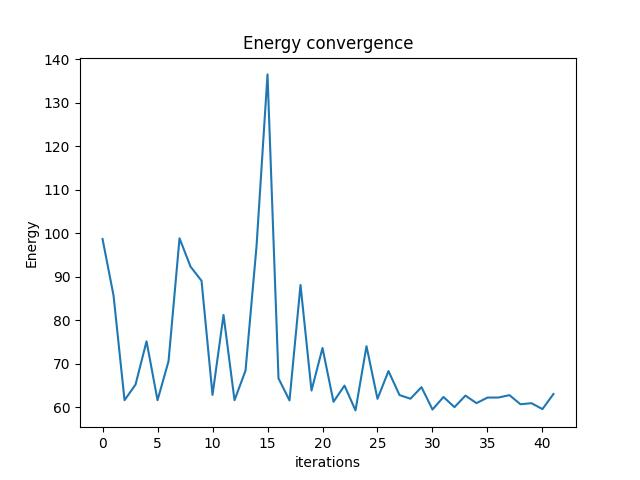

In [12]:
from classiq.execution import VQESolverResult

vqe_result = res[1].value
vqe_result.convergence_graph

# Optimization Results

We can also examine the statistics of the algorithm:

In [13]:
import pandas as pd

optimization_result = pd.DataFrame.from_records(res[0].value)
optimization_result.sort_values(by="cost", ascending=True).head(5)

,probability,cost,solution,count
438,0.001,5.0,"[0, 0, 1, 0, 1, 1, 1, 1]",1
883,0.001,6.0,"[1, 1, 1, 1, 0, 1, 1, 0]",1
1,0.001,13.0,"[0, 1, 1, 1, 0, 0, 0, 0]",1
177,0.001,14.0,"[0, 0, 0, 0, 1, 1, 1, 1]",1
125,0.001,14.0,"[0, 0, 0, 0, 1, 1, 1, 1]",1


And the histogram:

array([[<Axes: title={'center': 'cost'}>]], dtype=object)

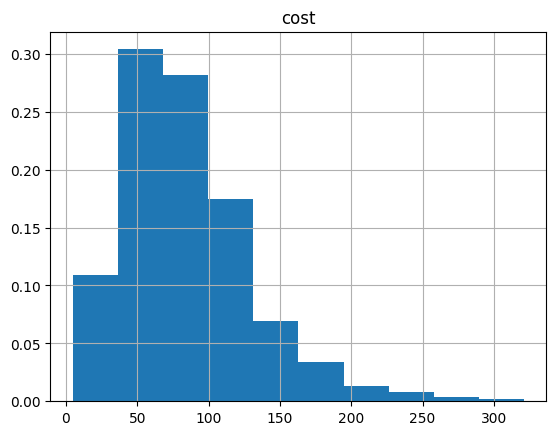

In [14]:
optimization_result.hist("cost", weights=optimization_result["probability"])

Let us plot the solution:

In [15]:
best_solution = optimization_result.solution[optimization_result.cost.idxmin()]

In [16]:
print(
    f"Quantum Solution: num_sets={int(sum(best_solution))}, sets={[sub_sets[i] for i in range(len(best_solution)) if best_solution[i]]}"
)

Quantum Solution: num_sets=5, sets=[[6, 7], [1, 6, 8], [3, 7, 9], [4, 7, 10], [2, 5, 8]]


Lastly, we can compare to the classical solution of the problem:

In [17]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(set_cover_model)

set_cover_model.display()

Model unknown

  Variables:
    x : Size=8, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   1.0 :     1 : False : False : Binary
          1 :     0 :   1.0 :     1 : False : False : Binary
          2 :     0 :   1.0 :     1 : False : False : Binary
          3 :     0 :   1.0 :     1 : False : False : Binary
          4 :     0 :   0.0 :     1 : False : False : Binary
          5 :     0 :   0.0 :     1 : False : False : Binary
          6 :     0 :   0.0 :     1 : False : False : Binary
          7 :     0 :   0.0 :     1 : False : False : Binary

  Objectives:
    cost : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True :   4.0

  Constraints:
    independent_rule : Size=10
        Key : Lower : Body : Upper
          1 :   1.0 :  1.0 :  None
          2 :   1.0 :  2.0 :  None
          3 :   1.0 :  2.0 :  None
          4 :   1.0 :  2.0 :  None
          5 :   1.0 :  1.0 :  None
          6 :   1.

In [18]:
classical_solution = [
    pyo.value(set_cover_model.x[i]) for i in range(len(set_cover_model.x))
]

In [19]:
print(
    f"Classical Solution: num_sets={int(sum(classical_solution))}, sets={[sub_sets[i] for i in range(len(classical_solution)) if classical_solution[i]]}"
)

Classical Solution: num_sets=4, sets=[[1, 2, 3, 4], [2, 3, 4, 5], [6, 7], [8, 9, 10]]



## References

<a id='SetCoverWiki'>[1]</a>: [Set Cover Problem (Wikipedia)](https://en.wikipedia.org/wiki/Set_cover_problem)

<a id='QAOA'>[2]</a>: [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

<a id='cvar'>[3]</a>: [Barkoutsos, Panagiotis Kl, et al. "Improving variational quantum optimization using CVaR." Quantum 4 (2020): 256.](https://arxiv.org/abs/1907.04769)
